**this will allow to connect with google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**First step to import the necessary libarary for the sickel cell project "plotly.express" is a Python data visualization library built on top of the plotly library.**

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from keras.applications import ResNet50V2
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, save_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
!pip install ruptures
import ruptures as rpt
import shutil
import seaborn as sns
import random
import itertools
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import applications
from tensorflow.keras.optimizers import Adam


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#!rm -r /content/content/Validation


**Loading the file Path**

In [ ]:
# Create the processed data directory if it does not exist
if not os.path.exists("content/processed_images"):
    os.makedirs("content/processed_images")

**Implementing Histogram to enhance the color contrast of the images**

In [ ]:
# Create a CLAHE object with desired parameters
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

# Loop through all images in the rawdata folder
for file_name in os.listdir("/content/drive/MyDrive/MDD/221025-SCS031 CHP"):
    # Read the image
    img_path = os.path.join("/content/drive/MyDrive/MDD/221025-SCS031 CHP", file_name)
    img = cv2.imread(img_path)

    # Apply CLAHE to the image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_clahe = clahe.apply(gray)

   # Convert the processed image to RGB
    img_rgb = cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2RGB)

    # Save the processed image in the processed_data folder
    out_path = os.path.join("content/processed_images", file_name)
    cv2.imwrite(out_path, img_rgb)


**Renaming Images because of spliting images into multiple folders cause it works with integer numbers. There might be a way to puse the original label of images but until now couldn't solve it**

In [ ]:
# Set the path to the directory containing the image files
img_dir = "content/processed_images"

# Get a list of image filenames sorted alphabetically
img_list = sorted(os.listdir(img_dir))

# Iterate through the list and rename each file
for i, old_name in enumerate(img_list):
    # Generate the new filename with leading zeros
    new_name = f"{i+1:04}.jpg"
    
    # Construct the full paths to the old and new files
    old_path = os.path.join(img_dir, old_name)
    new_path = os.path.join(img_dir, new_name)
    
    # Rename the file
    os.rename(old_path, new_path)

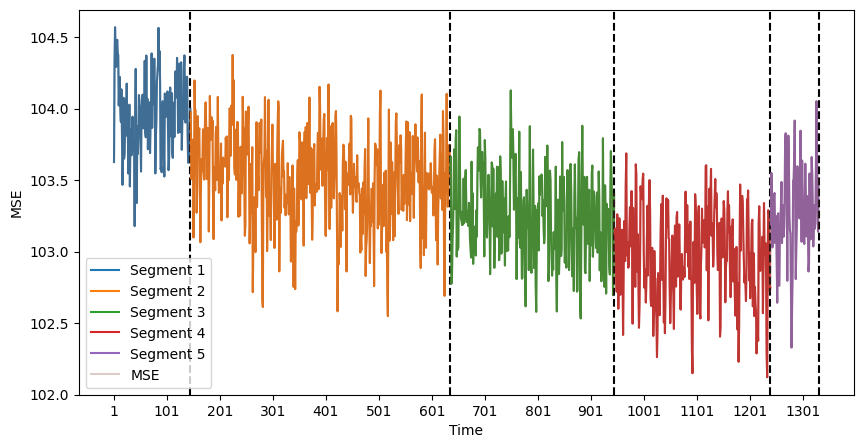

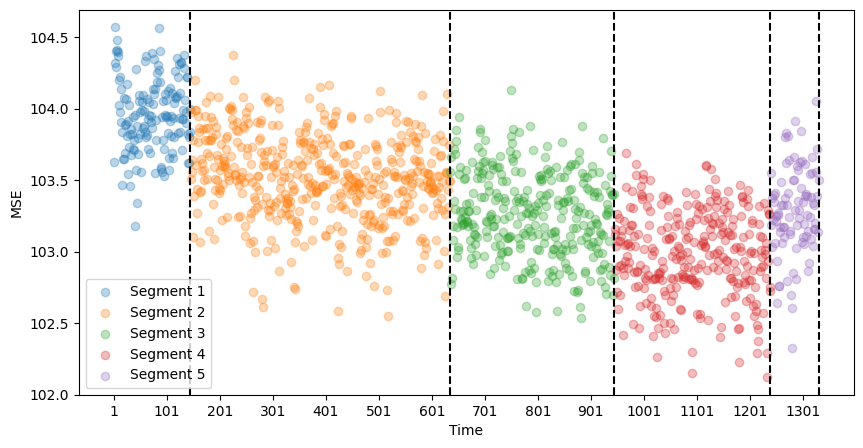

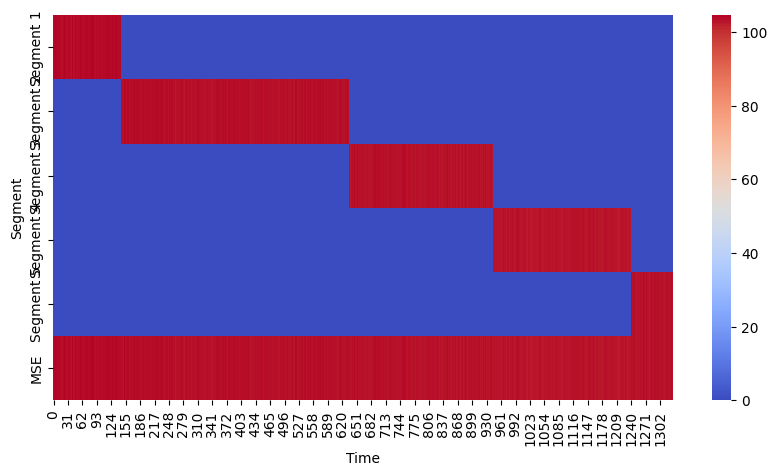

Changepoints: [145, 635, 945, 1240, 1331]


In [ ]:
# Load the list of images in the processed_data folder
image_list = os.listdir("content/processed_images")
# Sort the list of images by timestamp
image_list.sort()

# Create an empty list to store the MSE values
mse_values = []

# Loop through pairs of consecutive images and calculate the MSE
for i in range(len(image_list) - 1):
    # Read the two consecutive images
    img_path_1 = os.path.join("content/processed_images", image_list[i])
    img_path_2 = os.path.join("content/processed_images", image_list[i+1])
    img1 = cv2.imread(img_path_1)
    img2 = cv2.imread(img_path_2)
    # Compute the MSE between the two images
    mse = np.mean((img1 - img2)**2)

    # Add the MSE value to the list
    mse_values.append(mse)

# Create a time axis based on the timestamps in the image filenames
time_axis = [int(img.split(".")[0]) for img in image_list[:-1]]

# Run changepoint detection on the MSE values using the Pelt algorithm
model = "rbf"
algo = rpt.Pelt(model=model).fit(np.array(mse_values))
result = algo.predict(pen=10)
# Plot the segmented time series with changepoints
fig, ax = plt.subplots(figsize=(10, 5))
changepoints = []
for i, rpt_id in enumerate(result):
    if i == 0:
        start = 0
    else:
        start = result[i-1]
    end = result[i]
    ax.plot(time_axis[start:end], mse_values[start:end], label=f"Segment {i+1}")
    ax.axvline(x=time_axis[end-1], color='k', linestyle='--')  # add vertical line at changepoint
    changepoints.append(time_axis[end-1])  # add changepoint to the list
ax.plot(time_axis, mse_values, alpha=0.3, label="MSE")
ax.legend()
plt.xlabel("Time")
plt.ylabel("MSE")
plt.xticks(np.arange(time_axis[0], time_axis[-1], step=100))
plt.show()


#scatter plot
fig, ax = plt.subplots(figsize=(10, 5))
changepoints = []
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
for i, rpt_id in enumerate(result):
    if i == 0:
        start = 0
    else:
        start = result[i-1]
    end = result[i]
    ax.scatter(time_axis[start:end], mse_values[start:end], label=f"Segment {i+1}", alpha=0.3, color=colors[i])
    ax.axvline(x=time_axis[end-1], color='k', linestyle='--')  # add vertical line at changepoint
    changepoints.append(time_axis[end-1])  # add changepoint to the list
ax.legend()
plt.xlabel("Time")
plt.ylabel("MSE")
plt.xticks(np.arange(time_axis[0], time_axis[-1], step=100))
plt.show()

# Generate a 2D matrix with the MSE values and changepoints
matrix = np.zeros((len(changepoints) + 1, len(time_axis)))
for i in range(len(changepoints)):
    if i == 0:
        start = 0
    else:
        start = result[i-1]
    end = result[i]
    matrix[i, start:end] = mse_values[start:end]
matrix[-1, :] = mse_values

# Plot the heatmap
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(matrix, cmap="coolwarm", ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("Segment")
ax.set_yticklabels([f"Segment {i}" for i in range(1, len(changepoints) + 1)] + ["MSE"])
plt.show()


# Print the list of changepoints
print("Changepoints:", changepoints)

In [ ]:
#!rm -r /content/drive/MyDrive/MDD/Validation

**Copying and moving images to 5 classes according to the peak deformability that we got from the graph**

In [ ]:

# Create directories for the 5 classes
class1_dir = "/content/drive/MyDrive/MDD/Train/Phase1"
class2_dir = "/content/drive/MyDrive/MDD/Train/Phase2"
class3_dir = "/content/drive/MyDrive/MDD/Train/Phase3"
class4_dir = "/content/drive/MyDrive/MDD/Train/Phase4"
class5_dir = "/content/drive/MyDrive/MDD/Train/Phase5"

os.makedirs(class1_dir, exist_ok=True)
os.makedirs(class2_dir, exist_ok=True)
os.makedirs(class3_dir, exist_ok=True)
os.makedirs(class4_dir, exist_ok=True)
os.makedirs(class5_dir, exist_ok=True)

# Copy images to the appropriate class directories based on the changepoints
for i, rpt_id in enumerate(result):
    if i == 0:
        start = 0
    else:
        start = result[i-1]
    end = result[i]
    
    if i == 0:
        class_dir = class1_dir
    elif i == 1:
        class_dir = class2_dir
    elif i == 2:
        class_dir = class3_dir
    elif i == 3:
        class_dir = class4_dir
    else:
        class_dir = class5_dir
    
    for j in range(start, end):
        old_path = os.path.join("content/processed_images", f"{time_axis[j]:04}.jpg")
        new_path = os.path.join(class_dir, f"{time_axis[j]:04}.jpg")
        shutil.copy(old_path, new_path)

Now we are going to split 20% of images to test and validation folders randomly

In [ ]:
# Define directories for train, validation, and test folders
train_dir = "/content/drive/MyDrive/MDD/Train"
val_dir = "/content/drive/MyDrive/MDD/Validation"
test_dir = "/content/drive/MyDrive/MDD/Test"
classes = ["Phase1", "Phase2", "Phase3", "Phase4", "Phase5"]

# Create directories for the 5 classes in train, validation, and test folders
for dir_path in [train_dir, val_dir, test_dir]:
    for class_name in classes:
        os.makedirs(os.path.join(dir_path, class_name), exist_ok=True)

# Move 20% of images from each class directory in train folder to validation and test folders
for class_name in classes:
    class_dir = os.path.join(train_dir, class_name)
    val_class_dir = os.path.join(val_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    image_list = os.listdir(class_dir)
    num_images = len(image_list)
    num_val_images = int(num_images * 0.2)
    val_image_list = random.sample(image_list, num_val_images)
    test_image_list = random.sample(list(set(image_list) - set(val_image_list)), num_val_images)
    for img in val_image_list:
        old_path = os.path.join(class_dir, img)
        new_path = os.path.join(val_class_dir, img)
        shutil.move(old_path, new_path)
    for img in test_image_list:
        old_path = os.path.join(class_dir, img)
        new_path = os.path.join(test_class_dir, img)
        shutil.move(old_path, new_path)



In [ ]:
train_dir = '/content/drive/MyDrive/MDD/Train'
test_dir = '/content/drive/MyDrive/MDD/Test'
validation_dir = '/content/drive/MyDrive/MDD/Validation'





# Training with VGG16 pretrained Model


**Compiling the model and Applied Data Augmentation Techniques**

In [ ]:
# Dimensions of our images.
img_width, img_height = 224, 224


# Number of samples per batch.
batch_size = 32

# Use the VGG16 model with pre-trained weights
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Add new layers
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

# Freeze the VGG16 model weights
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


**Training the model**

In [ ]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))


Found 799 images belonging to 5 classes.
Found 266 images belonging to 5 classes.
Found 266 images belonging to 5 classes.
Epoch 1/30
25/25 [==============================] - 142s 6s/step - loss: 1.1860 - accuracy: 0.4994 - val_loss: 0.9790 - val_accuracy: 0.7068
Epoch 2/30
25/25 [==============================] - 62s 2s/step - loss: 1.1030 - accuracy: 0.5219 - val_loss: 0.8549 - val_accuracy: 0.7180
Epoch 3/30
25/25 [==============================] - 69s 3s/step - loss: 1.0256 - accuracy: 0.5707 - val_loss: 0.8314 - val_accuracy: 0.6729
Epoch 4/30
25/25 [==============================] - 62s 3s/step - loss: 1.0485 - accuracy: 0.5369 - val_loss: 0.8132 - val_accuracy: 0.7030
Epoch 5/30
25/25 [==============================] - 61s 2s/step - loss: 0.9658 - accuracy: 0.5982 - val_loss: 0.7331 - val_accuracy: 0.7143
Epoch 6/30
25/25 [==============================] - 64s 3s/step - loss: 0.9813 - accuracy: 0.5732 - val_loss: 0.8593 - val_accuracy: 0.6579
Epoch 7/30
25/25 [==================

**Model Evaluation**

In [ ]:
# Evaluate the model on the test set
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
test_loss, test_acc = model.evaluate(test_generator, steps=test_steps_per_epoch)
print('Test accuracy:', test_acc)

9/9 [==============================] - 32s 4s/step - loss: 0.7105 - accuracy: 0.6729
Test accuracy: 0.6729323267936707


**Confusion Matrix**

9/9 [==============================] - 14s 1s/step
[[ 0 18  7  4  0]
 [ 0 45 16 37  0]
 [ 0 26 11 25  0]
 [ 0 32 10 17  0]
 [ 0  7  4  7  0]]


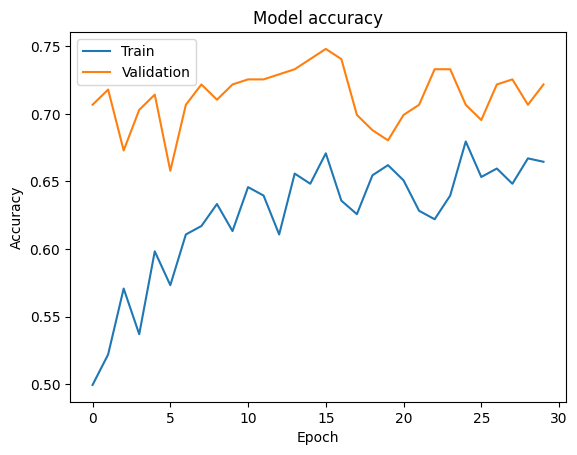

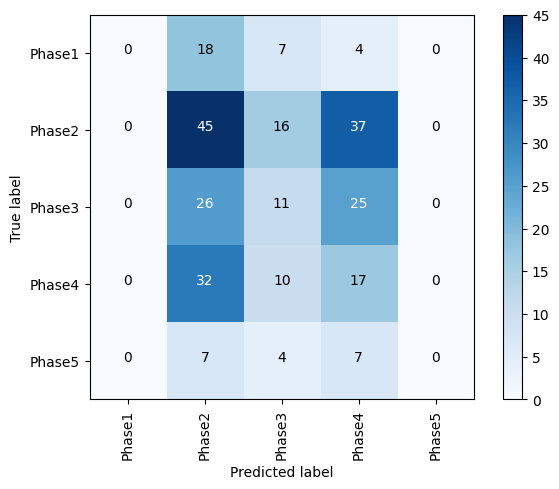

In [ ]:
# Compute the confusion matrix
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
y_true = test_generator.classes
y_pred = np.argmax(predictions, axis=-1)
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Plot the accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices, rotation=90)
plt.yticks(tick_marks, test_generator.class_indices)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



# Use the ResNet50V2 model

Found 799 images belonging to 5 classes.
Found 266 images belonging to 5 classes.
Found 266 images belonging to 5 classes.
Epoch 1/30
25/25 [==============================] - 78s 3s/step - loss: 13.6185 - accuracy: 0.3467 - val_loss: 1.5479 - val_accuracy: 0.4662
Epoch 2/30
25/25 [==============================] - 68s 3s/step - loss: 1.4104 - accuracy: 0.4456 - val_loss: 1.2195 - val_accuracy: 0.5075
Epoch 3/30
25/25 [==============================] - 64s 3s/step - loss: 1.2680 - accuracy: 0.5044 - val_loss: 1.0133 - val_accuracy: 0.5940
Epoch 4/30
25/25 [==============================] - 70s 3s/step - loss: 1.1937 - accuracy: 0.5232 - val_loss: 1.0047 - val_accuracy: 0.6053
Epoch 5/30
25/25 [==============================] - 69s 3s/step - loss: 1.1040 - accuracy: 0.5407 - val_loss: 1.0062 - val_accuracy: 0.5677
Epoch 6/30
25/25 [==============================] - 69s 3s/step - loss: 1.1245 - accuracy: 0.5532 - val_loss: 1.0266 - val_accuracy: 0.6165
Epoch 7/30
25/25 [==================

<ipython-input-17-f85d25b1445c>:56: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_generator, steps=test_steps_per_epoch)


Test accuracy: 0.6015037298202515


<ipython-input-17-f85d25b1445c>:60: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator, steps=test_steps_per_epoch)


[[ 2 14  3  9  1]
 [ 4 44 14 35  1]
 [ 7 25  7 22  1]
 [ 7 30  5 17  0]
 [ 0  7  3  8  0]]


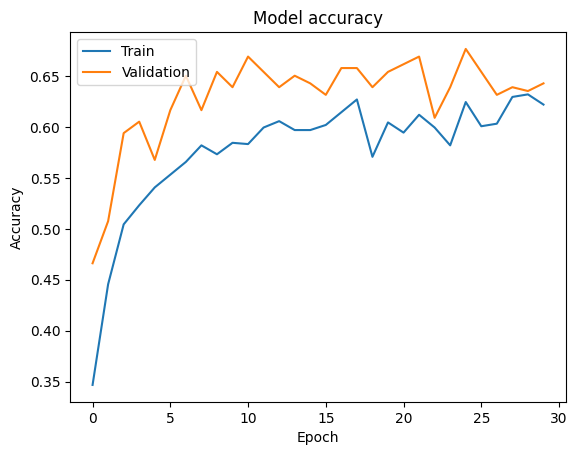

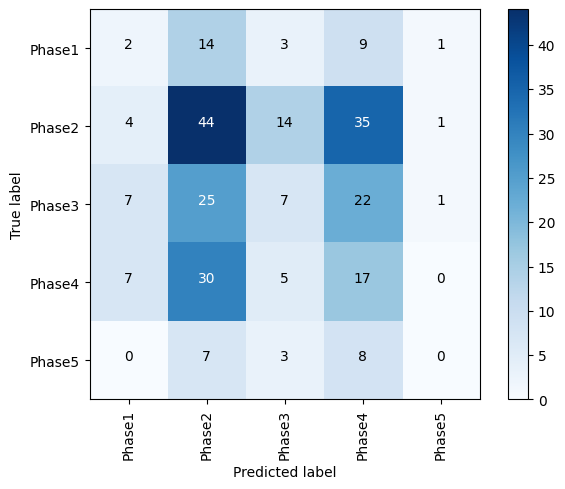

In [ ]:
# Use the ResNet50V2 model with pre-trained weights
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Add new layers
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

# Freeze the ResNet50V2 model weights
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

# Evaluate the model on the test set
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
test_loss, test_acc = model.evaluate(test_generator, steps=test_steps_per_epoch)
print('Test accuracy:', test_acc)

# Compute the confusion matrix
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
y_true = test_generator.classes
y_pred = np.argmax(predictions, axis=-1)
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Plot the accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices, rotation=90)
plt.yticks(tick_marks, test_generator.class_indices)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

